Dataset1: https://www.kaggle.com/pranavraikokte/covid19-image-dataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [5]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.1 MB/s eta 0:00:00


# Import Libraries & Modules

In [77]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm
from rich import print

torch.manual_seed(0)

# Load Dataset and read images

## transform

In [7]:
train_transform = transforms.Compose([transforms.Resize(size = (224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.4954, 0.4954, 0.4955],
                                                            std=[0.2801, 0.2801, 0.2801])])

test_transform = transforms.Compose([transforms.Resize(size = (224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4954, 0.4954, 0.4955],
                                                          std=[0.2801, 0.2801, 0.2801])])

## Load dataset

In [8]:
train_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Datasets/Covid19-dataset/train',
                                             transform=train_transform)

test_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Datasets/Covid19-dataset/test',
                                            transform=test_transform)

In [9]:
print(train_data.class_to_idx)
print(test_data.class_to_idx)

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [10]:
def count_class_img(dataset):
    count_class = {'Covid': 0,
                   'Normal': 0,
                   'Viral': 0}

    for i in dataset.imgs:
        if i[1] == 0:
            count_class['Covid'] += 1
        elif i[1] == 1:
            count_class['Normal'] += 1
        else:
            count_class['Viral'] += 1

    # print(f'{count_class} => sum class={sum(count_class.values())}')
    return count_class

In [11]:
count_class_img(train_data), count_class_img(test_data)

({'Covid': 111, 'Normal': 70, 'Viral': 70},
 {'Covid': 26, 'Normal': 20, 'Viral': 20})

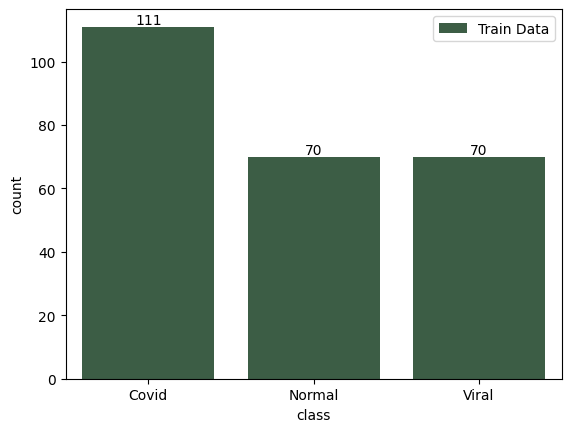

In [83]:
df = count_class_img(train_data)
df = pd.DataFrame({'class': df.keys(), 'count': df.values()})

ax = sns.barplot(x='class', y='count', data=df, label='Train Data', color='#376242')
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.legend()

## DataLoader

In [6]:
batch_size = 6

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=11, shuffle=False)

print('Number of training batches', len(train_loader))
print('Number of test batches', len(test_loader))

Number of training batches 42

Number of test batches 6

# Show Images

In [7]:
class_names = train_data.classes

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

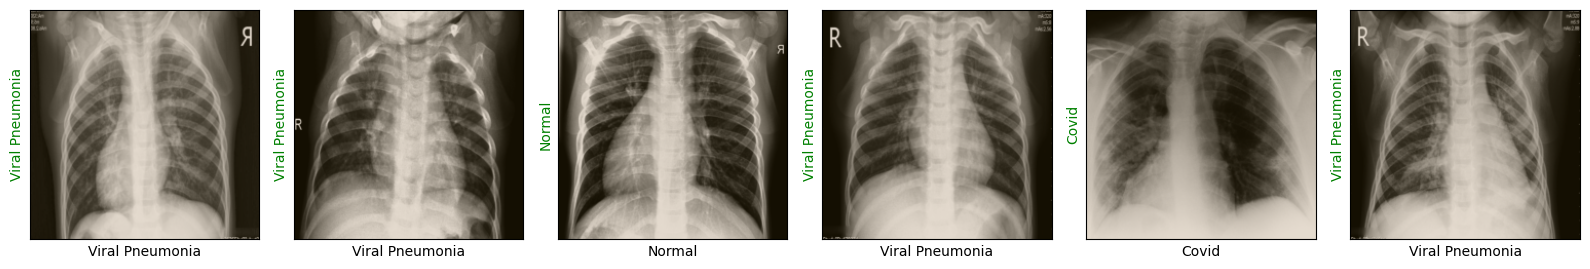

In [8]:
images, labels = next(iter(train_loader))
show_images(images, labels, labels)

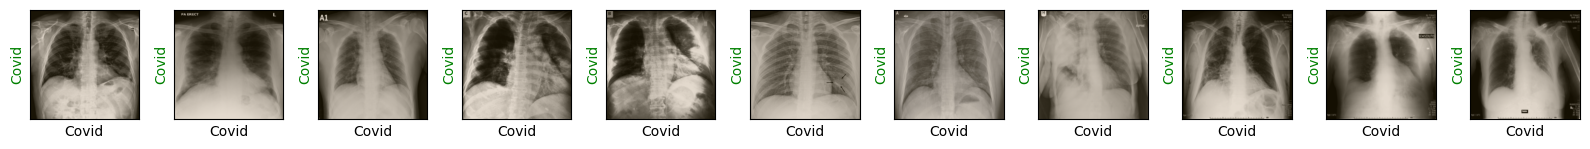

In [9]:
images, labels = next(iter(test_loader))
show_images(images, labels, labels)

In [14]:
def show_preds():
    model.eval()
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())

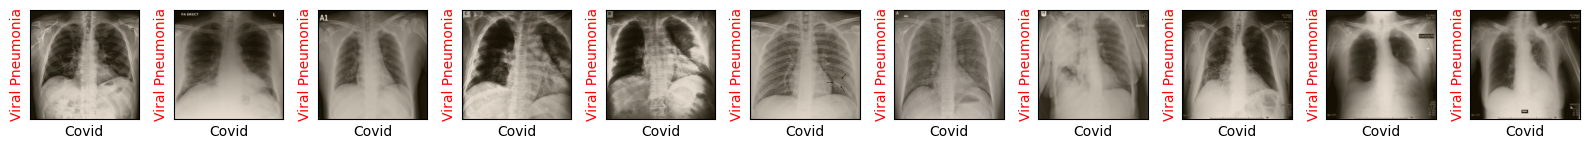

In [15]:
show_preds()

# Create model Resnet(18layer)

In [10]:
model = torchvision.models.resnet18(pretrained = True)

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): 

In [12]:
#hyperparameters
in_features = 512
out_features = 3
lr = 3e-5 #lr=0.00003

model.fc = torch.nn.Linear(in_features=in_features, out_features=out_features)

# Device

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Loss function & Optimizer

In [16]:
# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Utils

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Train Model

In [47]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task='multiclass', num_classes=3).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch {epoch}')
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item())
            acc_train(outputs, targets.int())

            tepoch.set_postfix(loss=loss_train.avg,
                                accuracy=100.*acc_train.compute().item())
    return model, loss_train.avg, acc_train.compute().item()

# Evaluation Model

In [48]:
def evaluate(model, eval_loader, loss_fn):
    model.eval()

    with torch.no_grad():
        loss_eval = AverageMeter()
        acc_eval = Accuracy(task='multiclass', num_classes=3).to(device)

        for i, (inputs, targets) in enumerate(eval_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            loss_eval.update(loss.item())
            acc_eval(outputs, targets.int())
    show_preds()
    return loss_eval.avg, acc_eval.compute()

Epoch 0: 100%|██████████| 42/42 [00:18<00:00,  2.31batch/s, accuracy=100, loss=0.0286]


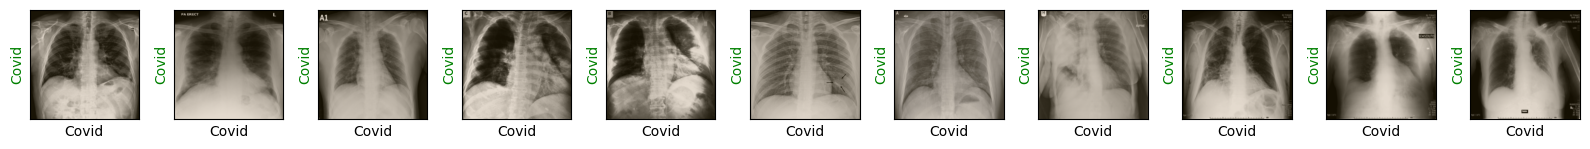

Valid: Loss=0.047, Accuracy=1e+02

Epoch 1: 100%|██████████| 42/42 [00:19<00:00,  2.19batch/s, accuracy=98.4, loss=0.0614]


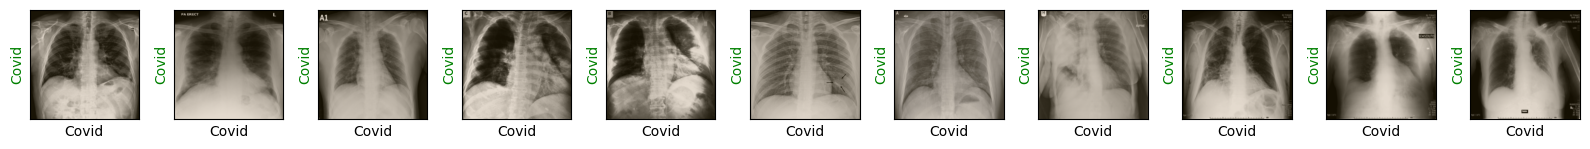

Valid: Loss=0.038, Accuracy=1e+02

Epoch 2: 100%|██████████| 42/42 [00:19<00:00,  2.17batch/s, accuracy=100, loss=0.0155]


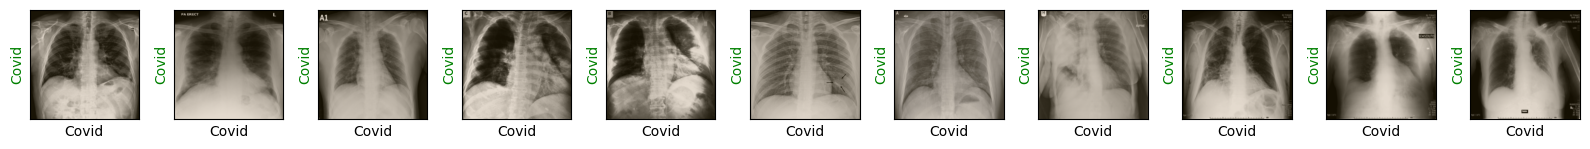

Valid: Loss=0.054, Accuracy=1e+02

Epoch 3: 100%|██████████| 42/42 [00:18<00:00,  2.24batch/s, accuracy=97.2, loss=0.0696]


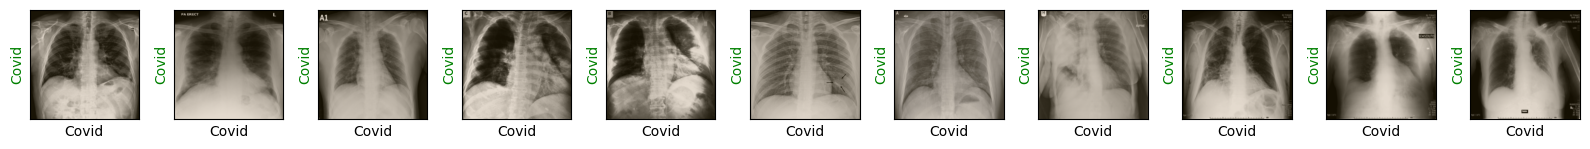

Valid: Loss=0.023, Accuracy=1e+02

Epoch 4: 100%|██████████| 42/42 [00:19<00:00,  2.21batch/s, accuracy=98.8, loss=0.0374]


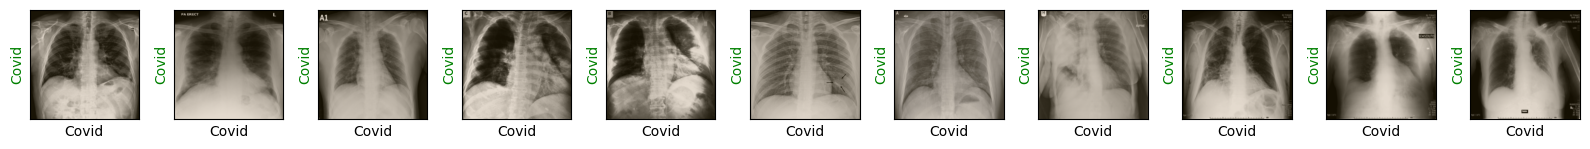

Valid: Loss=0.019, Accuracy=1e+02

In [49]:
num_epochs = 5

for epoch in range(num_epochs):
    model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)

    loss_test, acc_test = evaluate(model,
                                   test_loader,
                                   loss_fn)

    print(f'Valid: Loss={loss_test:.2}, Accuracy={100 * acc_test:.2}\n')